In [13]:
import matplotlib.pyplot as plt
import math, time, sys
import numpy as np

In [14]:
# set constants
q = 1.6e-19
k = 1.38e-23 / q

In [17]:
# define the class, counts the essential features of semiconductor
class Si:

    def __init__(self):
        # set constants
        self.m_dn = 1.08
        self.m_dp = 0.59
        self.epsilon = 11.7
        self.mu_n_300 = 1350
        self.mu_p_300 = 450

    def Eg(self, temperature):
        return 1.17 - 4.73e-4 / (temperature + 636) * temperature ** 2

    def Ei(self, temperature):
        return self.Eg(temperature) / 2 - k * temperature / 4

    # C_minus, C_plus, C_doubleminus - parameters of the process
    def C_minus(self, temperature):
        return math.exp((self.Ei(temperature) + 0.57 - self.Eg(temperature)) / k / temperature)

    def C_plus(self, temperature):
        return math.exp((0.35 - self.Ei(temperature)) / k / temperature)

    def C_doubleminus(self, temperature):
        return math.exp((2 * self.Ei(temperature) + 1.25 - 3 * self.Eg(temperature)) / k / temperature)

    def gamma_l(self, temperature):
        return 2620 * math.exp(-1.1 / k / temperature)

    def gamma_p(self, temperature):
        return 9.63e-16 * math.exp(2.83 / k / temperature)

    def Vn(self, temperature, n):
        numerator =  1 + self.C_plus(temperature) * (self.ni(temperature) / n) \
                + self.C_minus(temperature) * (n / self.ni(temperature)) \
                + self.C_doubleminus(temperature) * ( n / self.ni(temperature)) ** 2
        denominator = 1 + self.C_plus(temperature) + self.C_minus(temperature) + self.C_doubleminus(temperature)
        return numerator / denominator

    def Nv(self, temperature):
        return 4.82e15 * (self.m_dp ** 1.5) * (temperature ** 1.5)

    def Nc(self, temperature):
        return 4.82e15 * (self.m_dn ** 1.5) * (temperature ** 1.5)

    def ni(self, temperature):
        return ((self.Nc(temperature) * self.Nv(temperature)) ** 0.5) * math.exp(
            -1 * self.Eg(temperature) / (2 * temperature * k))

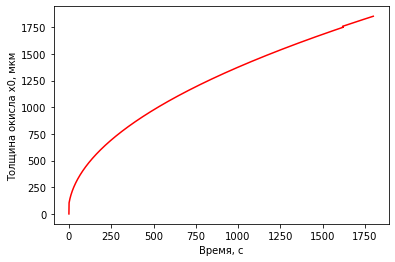

In [18]:
def K(A, Ea, temperature):
    return A * math.exp(- Ea / k / temperature)


def x_t(t, A, B, xi):
    tau = (xi ** 2 + A * xi) / B
    return (A / 2) * (math.sqrt(1 + (t + tau) / ((A**2)/4*B)) - 1)

Si = Si()

def oxidation(time, T, concentration, xi):
    sc = Si
    B = K(12.9, 1.23, T) * (1 + sc.gamma_p(T) * sc.ni(T) ** 0.22)
    A = B / (K(1.04e5, 2, T) * (1 + sc.gamma_l(T) * (sc.Vn(T, concentration) - 1)))
    # вызов функции расчета толщины оксида с новыми параметрами
    x = x_t(time, A, B, xi)
    return x

def oxide(T, time, concentration1, concentration2, x0, xi):
    sc = Si

    n = time * 60
    t = np.empty(n)
    x = np.empty(n)
    t[0] = 0
    x[0] = 50e-3
    xi = 0.1

    for i in range(1, n):
        t[i] = t[i - 1] + 1
        # расчет окисла при первой концентрации - 1e15 До глубины 0.1 / 0.45
        if x[i] < x0 * 2.43:
            x[i] = oxidation(t[i], T, concentration1, x0)
        # расчет окисла с новой концентрацией
        else:
            x[i] = oxidation(t[i], T, concentration2, xi)

    plt.plot(t, x, c = 'red')
    plt.ylabel('Толщина окисла x0, мкм')
    plt.xlabel('Время, c')
    plt.show()

oxide(1373, 30, 1e15, 1e17, 50e-3, 0.1)